In [1]:
import numpy as np 
import pandas as pd
import logging 
from dateutil import parser
import time
from datetime import date, timedelta
import datetime
import matplotlib.pyplot as plt 
% matplotlib inline
import logging
import redis
import zlib
import os 


download_dir = "X:\\Data_Analytics\\Basis_Project\\5min_market_data\\"
master_dir = "X:\\Data_Analytics\\Basis_Project\\Master\\"
log_path = "X:\\Data_Analytics\\Basis_Project\\"


logging.basicConfig(filename=log_path+"test.log",
                        level=logging.DEBUG,
                        format="%(asctime)s:%(levelname)s:%(message)s")



def redis_key_generator():
    '''Generate all the keys needed for computation over a period of day '''
    
    # read master file for cash and fut codes 
    #symbols = pd.read_excel(master_dir+'PairMaster.xlsx')['Symbol']
    # redis server connection
    #r = redis.Redis(host='localhost', port=6379)
    keys = []
    timekeys = []
    a = datetime.datetime(1,1,1,9,5)
    for i in range(77):
        a = a + datetime.timedelta(minutes=5)
        timekeys.append("{}{}".format(('0'+str(a.hour) if len(str(a.hour))==1 else str(a.hour)),
                                      ( '0'+str(a.minute) if len(str(a.minute))==1 else str(a.minute)))) 

    '''
    for symbol in symbols:
        for time in timekeys:
            keys.append(symbol+'.'+time)
            
    for key in keys:
        r.set(key, '') '''
        
    return timekeys


def gen_filename(timekeys):
    '''Generate filenames'''
    
    date = datetime.date.today()
    filename = []
    for time in timekeys:
        filename.append( 'debug_log_mktdata_{}{}{}_{}.txt'.format(('0'+str(date.day) if len(str(date.day))==1 else str(date.day)),
                                                ('0'+str(date.month) if len(str(date.month))==1 else str(date.month)),
                                                str(date.year), time ))
        
    return filename


def dateparse(row):
    '''Func to parse dates while reading ticker files'''
    date = row.split("+")[0]
    date = pd.to_datetime(date, format='%Y-%m-%d %H:%M:%S')
    return date
    

def aggregate_func(prices):
    '''Func to return max of volume traded and mean of LTP for 5 sec ticker data'''
    
    # read master file for cash and fut codes 
    pairmaster = pd.read_excel(master_dir+'PairMaster.xlsx')
    
    # loop through all securities in master file and generate stats:
    result = pd.DataFrame()
    for index, row in pairmaster.iterrows():
        try:            
            # filter for NFO and Futcode
            df = prices[prices['ExchangeSegment']=='NFO']
            df = df[df['SecurityCode']==row['FutCode']]       
            
            df['Symbol']=row['Symbol']            
            # groupby timegrouper        
            df = df.groupby(['Symbol', pd.Grouper(key='date', freq='5s')]).agg({'VolumeTraded':'max','LTP':'mean'})
            df['Exchange'] = 'NFO'
            result = result.append(df)
            
            # filter for NSE and Cashcode            
            df = prices[prices['ExchangeSegment']=='NSE']
            df = df[df['SecurityCode']==row['CashCode']]
            df['Symbol']=row['Symbol']            
            # groupby timegrouper        
            df = df.groupby(['Symbol', pd.Grouper(key='date', freq='5s')]).agg({'VolumeTraded':'max','LTP':'mean'})
            df['Exchange'] = 'NSE'
            result = result.append(df)         
            
        except Exception as e:
            print e            
            
    return result 

def summary_func(result):
    '''Func to generate summary data'''
    
    # cash df for NSE
    cash_df = result[result['Exchange']=='NSE']
    # fill na with forward pads i.e. copy value as it is in forward timestamp
    cash_df.fillna(method='pad', inplace=True)
    # difference of volume traded with cconsecutive time bound 
    cash_df['Volume_cash'] = cash_df.groupby('Symbol')['VolumeTraded'].diff()
    cash_df['Volume_cash'] = cash_df['Volume_cash'].fillna(cash_df['VolumeTraded'])

    fut_df = result[result['Exchange']=='NFO']
    # fill na with forward pads i.e. copy value as it is in forward timestamp
    fut_df.fillna(method='pad', inplace=True)
    # difference of volume traded with cconsecutive time bound 
    fut_df['Volume_fut'] = fut_df.groupby('Symbol')['VolumeTraded'].diff()
    fut_df['Volume_fut'] = fut_df['Volume_fut'].fillna(fut_df['VolumeTraded'])
    
    # merge cash and futures df
    temp = cash_df.reset_index().assign(key=cash_df.index.get_level_values(1)).merge(fut_df.reset_index().assign(key=fut_df.index.get_level_values(1)),
                                                                          on=['key','Symbol'], how='outer', suffixes=('_cash','_fut')).set_index(['Symbol']).drop(columns=['date_cash','date_fut','Exchange_cash','Exchange_fut'], axis=1)[['key','VolumeTraded_cash','LTP_cash','VolumeTraded_fut','LTP_fut','Volume_cash','Volume_fut']]

    temp.rename(columns={'key':'date'}, inplace=True)
    # fill non tarded time with zeros on merged df
    temp.fillna(0, inplace=True)

    # min of volume cash and future
    temp['cfvolume'] = temp[['Volume_cash','Volume_fut']].min(axis=1, numeric_only=True)
    
    # calc spread of price:ltp
    temp['spread_ab'] = temp['LTP_fut'] - temp['LTP_cash']
    # spread in 10,000 bps
    temp['spread_bps'] = temp['spread_ab']*10000/temp['LTP_cash']
    # replace inf with zeros; zero divison handling for cash=0
    temp.replace(np.inf, 0, inplace=True)
    
    return temp   
   
    
    
    
def ticker_generator(starttime,endtime, filename):
    '''Func to read 5 min logutility file and generate 5 sec ticker stats for volume traded and LTP for each symbol''' 
    
        
    cols = ['Date','Symbol','QtyBuy int','QtyBuy_2','QtyBuy_3','QtyBuy_4','QtyBuy_5','Bid','Bid_2','Bid_3','Bid_4','Bid_5','offer',
        'Offer_2','Offer_3','Offer_4','Offer_5','QtySell','QtySell_2','QtySell_3','QtySell_4','QtySell_5','VolumeTraded',
        'OpenPrice','Ccy', 'LTP','NumberOfOrdersBuy','NumberOfOrdersBuy_2','NumberOfOrdersBuy_3','NumberOfOrdersBuy_4',
        'NumberOfOrdersBuy_5','NumberOfOrdersSell','NumberOfOrdersSell_2','NumberOfOrdersSell_3','NumberOfOrdersSell_4',
        'NumberOfOrdersSell_5','LowerCircuitLimit','UpperCircuitLimit','HighPrice','LowPrice','ClosePrice','LTT timestamp',
        'NetChangeIndicator','LTQ','LotSize','OI','SecurityCode','ExchangeSegment','TradingSymbol']
    
    prices_df = pd.DataFrame(); prices_df_1 = pd.DataFrame()    
    
    try:  
        print download_dir+filename[0]
        # read input file for every 5 sec data 
        prices_df = pd.read_csv(download_dir+filename[0],delimiter=',', engine='c',date_parser=dateparse, 
                                parse_dates={'date':[0]}, names=cols,skipinitialspace=True, low_memory=False )[['date','Symbol','VolumeTraded','LTP','SecurityCode','ExchangeSegment']]
        
        logging.info('Sucessfully read ticker file {}'.format(filename[0]))
        
    except Exception as e :
        logging.info('No file with name {}'.format(filename[0]))
        
        
    try:        
        prices_df_1 = pd.read_csv(download_dir+filename[1],delimiter=',', engine='c',date_parser=dateparse,
                                  parse_dates={'date':[0]}, names=cols,skipinitialspace=True, low_memory=False )[['date','Symbol','VolumeTraded','LTP','SecurityCode','ExchangeSegment']]
        
        logging.info('Sucessfully read ticker file {}'.format(filename[1]))
        
    except Exception as e :        
        logging.info('No file with name {}'.format(filename[1]))
           
        

    # concat two dataframes
    prices_df = pd.concat([prices_df, prices_df_1], axis=0)
       
    # retain records between market hours and ignore rest
    prices_df['time'] = prices_df['date'].dt.time   
    prices = prices_df[ (prices_df['time']>= starttime ) & (prices_df['time']< endtime)]     
    
    # ignore codes with long codes
    prices = prices[ ~(prices.SecurityCode.str.len() > 6 ) ]

    # cpnvert to numeric
    prices['SecurityCode'] = pd.to_numeric(prices['SecurityCode'], errors='coerce') 
    prices.to_csv('ticker.csv')
    
    # final result 
    result = aggregate_func(prices)
    # get summary data for cashtill now and future till now;
    result = summary_func(result)
    
    return result
    
    
def main():
    '''Func to read files, process and do scheduling of entire process'''
    
    # create redis keys
    timekeys = redis_key_generator()
    # get filenames to be processed over a time 
    files = gen_filename(timekeys)
    filenames = []
    for index, f in enumerate(files):
        try:
            filenames.append( [files[index-1], f] )
        except Exception as e:
            print 'Error'
        
    filenames.pop(0)    
    # redis connection 
    r = redis.Redis(host='localhost', port=6379)
    
    for index, filename in enumerate(filenames):
        while not os.path.exists(download_dir+filename[1]):            
            time.sleep(15)
        else:                 
            start = time.time()  
            result = ticker_generator(datetime.time(int(filenames[index-1][1].split('_')[-1].split('.')[0][:2]),
                                           int(filenames[index-1][1].split('_')[-1].split('.')[0][2:]) ),
                             datetime.time(int(filenames[index][1].split('_')[-1].split('.')[0][:2]), 
                                           int(filenames[index][1].split('_')[-1].split('.')[0][2:]) )
                             ,filename)           
            
            r.set('{}'.format('_'.join(filename[1].split('_')[-2:])[:-4]), result.to_msgpack(compress='zlib'))
            #res = pd.read_msgpack(r.get('df'))            
            
            print 'Time taken : {}'.format(time.time()-start)
                 
                
    # delete all keys from redis db
    #r.flushall()

if __name__ == '__main__':
    main()

#print "Execution time: {0} Seconds.... ".format(end_time - start_time)

KeyboardInterrupt: 

In [78]:
r = redis.Redis(host='localhost', port=6379)



In [101]:
r.keys('08*')

['08012019_0920', '08012019_0915', '08012019_0925']

In [99]:
pd.read_msgpack(r.get(r.keys('08*')[-1]))


date  VolumeTraded_cash     LTP_cash  \
Symbol                                                           
EXIDEIND   2019-01-04 09:20:00            16484.0   259.535714   
EXIDEIND   2019-01-04 09:20:05            17284.0   259.450000   
EXIDEIND   2019-01-04 09:20:10            17335.0   259.450000   
EXIDEIND   2019-01-04 09:20:15            17387.0   259.385714   
EXIDEIND   2019-01-04 09:20:20            17433.0   259.350000   
EXIDEIND   2019-01-04 09:20:25            17533.0   259.316667   
EXIDEIND   2019-01-04 09:20:30            17533.0   259.300000   
EXIDEIND   2019-01-04 09:20:35            17533.0   259.300000   
EXIDEIND   2019-01-04 09:20:40            17692.0   259.360000   
EXIDEIND   2019-01-04 09:20:45            18472.0   259.420000   
EXIDEIND   2019-01-04 09:20:50            18811.0   259.421429   
EXIDEIND   2019-01-04 09:20:55            19081.0   259.435714   
EXIDEIND   2019-01-04 09:21:00            19191.0   259.528571   
EXIDEIND   2019-01-04 09:21:05            19201.0   259.575000   
EXIDEIND   2019-01-04 09:21:10            19201.0   259.550000   
EXIDEIND   2019-01-04 09:21:15            19206.0   259.500000   
EXIDEIND   2019-01-04 09:21:20            19206.0   259.450000   
EXIDEIND   2019-01-04 09:21:25            19206.0   259.450000   
EXIDEIND   2019-01-04 09:21:30            19206.0   259.450000   
EXIDEIND   2019-01-04 09:21:35            19547.0   259.360000   
EXIDEIND   2019-01-04 09:21:40            21726.0   259.662500   
EXIDEIND   2019-01-04 09:21:45            21892.0   259.740000   
EXIDEIND   2019-01-04 09:21:50            21892.0   259.750000   
EXIDEIND   2019-01-04 09:21:55            21902.0   259.630000   
EXIDEIND   2019-01-04 09:22:00            21902.0   259.600000   
EXIDEIND   2019-01-04 09:22:05            21902.0   259.600000   
EXIDEIND   2019-01-04 09:22:10            21912.0   259.750000   
EXIDEIND   2019-01-04 09:22:15            21942.0   259.666667   
EXIDEIND   2019-01-04 09:22:20            21942.0   259.600000   
EXIDEIND   2019-01-04 09:22:25            21948.0   259.600000   
...                        ...                ...          ...   
DIVISLAB   2019-01-04 09:23:45            31276.0  1443.816667   
DIVISLAB   2019-01-04 09:23:50            31282.0  1443.942857   
DIVISLAB   2019-01-04 09:23:55            31436.0  1443.312500   
DIVISLAB   2019-01-04 09:24:00            31436.0  1443.800000   
DIVISLAB   2019-01-04 09:24:05            31436.0  1443.800000   
DIVISLAB   2019-01-04 09:24:10            31487.0  1442.664286   
DIVISLAB   2019-01-04 09:24:15            31596.0  1443.000000   
DIVISLAB   2019-01-04 09:24:20            31617.0  1443.285714   
DIVISLAB   2019-01-04 09:24:25            31617.0  1443.125000   
DIVISLAB   2019-01-04 09:24:30            31665.0  1443.585714   
DIVISLAB   2019-01-04 09:24:35            31775.0  1443.300000   
DIVISLAB   2019-01-04 09:24:40            31880.0  1443.880000   
DIVISLAB   2019-01-04 09:24:45            31938.0  1443.755556   
DIVISLAB   2019-01-04 09:24:50            32048.0  1443.481250   
DIVISLAB   2019-01-04 09:24:55            32498.0  1443.306250   
IDBI       2019-01-04 09:20:40                0.0     0.000000   
IDBI       2019-01-04 09:22:05                0.0     0.000000   
IFCI       2019-01-04 09:23:55                0.0     0.000000   
CASTROLIND 2019-01-04 09:22:25                0.0     0.000000   
JPASSOCIAT 2019-01-04 09:24:20                0.0     0.000000   
BERGEPAINT 2019-01-04 09:21:20                0.0     0.000000   
BERGEPAINT 2019-01-04 09:24:40                0.0     0.000000   
HINDZINC   2019-01-04 09:24:05                0.0     0.000000   
AMARAJABAT 2019-01-04 09:23:15                0.0     0.000000   
NHPC       2019-01-04 09:22:25                0.0     0.000000   
RAMCOCEM   2019-01-04 09:20:20                0.0     0.000000   
RAMCOCEM   2019-01-04 09:20:30                0.0     0.000000   
RAMCOCEM   2019-01-04 09:24:50                0.0     0.000000   


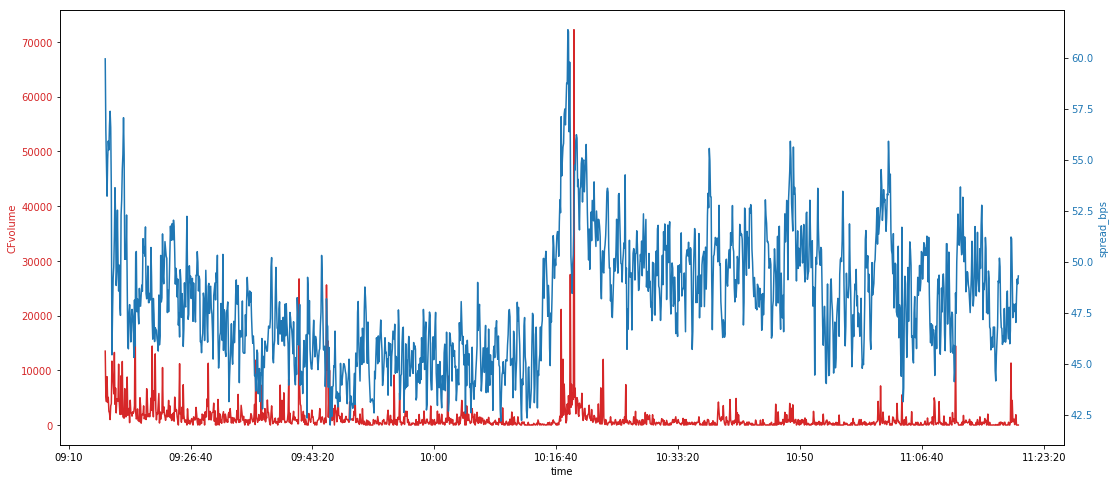

In [57]:
result['time'] = result['date'].dt.time
df = result.loc['RELIANCE'].reset_index()[['time','cfvolume','spread_bps']].set_index('time')

# plot graph for cf volume and spreadbps 
fig, ax1 = plt.subplots(figsize=(18,8))
color = 'tab:red'
ax1.set_xlabel('time')
ax1.set_ylabel('CFvolume', color=color)
ax1.plot(df.index, df.cfvolume, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('spread_bps', color=color)  # we already handled the x-label with ax1
ax2.plot(df.index, df.spread_bps, color=color)
ax2.tick_params(axis='y', labelcolor=color)

 # otherwise the right y-label is slightly clipped
plt.show()

### Code to set params from excel file and publish it to redis db

In [27]:
# Reading parameters from excel file 
# hello.py
import numpy as np
import xlwings as xw
import pandas as pd
import datetime as dt
from datetime import date
import matplotlib.pyplot as plt


def get_timer(length):
    '''Func to get start and end times for processing '''
    
    time_buckets = [datetime.time(9,15),datetime.time(10,0),datetime.time(10,30),datetime.time(11,0),datetime.time(11,30),
                 datetime.time(12,0),datetime.time(12,30),datetime.time(13,0),datetime.time(13,30),datetime.time(14,0),
                 datetime.time(14,30),datetime.time(15,0),datetime.time(15,30)]
    
    time_range = [i for i in range(3,39,3)]
    
    if length in time_range:
        index =  time_range.index(length)
        return time_buckets[index],time_buckets[index+1]

    
    
def show_results():
    # read files published on redis 
    r = redis.Redis(host='localhost', port=6379)
    # read all keys for today
    day_keys = r.keys(''.join(str(datetime.datetime.today().date()).split('-')[::-1])+'*')
    day_keys = sorted(day_keys)
    
    fro = 0; to =-1
    try:
        fro = day_keys.index(day_keys[0].split('_')[0]+"_"+''.join(str(starttime)[:-3].split(':')))
    except:
        pass

    try:
        to = day_keys.index(day_keys[0].split('_')[0]+"_"+''.join(str(endtime)[:-3].split(':')))
    except:
        pass
    
    files = day_keys[fro:] if to == -1 else day_keys[fro:to+1]
    
    df = pd.concat([pd.read_msgpack(r.get()) ], axis=0)
    
    for symbol in symbols:
        pass


def get_params():
    '''Func to show all the set parameters till now'''
    
    # read files published on redis 
    r = redis.Redis(host='localhost', port=6379)
    # fetch all published parameters so far
    dividends = r.keys('*_dividend*')
    fa = r.keys('*_fa*')
    ra = r.keys('*_ra*')    
      
    # mock caller for debugging 
    xw.Book('X:\Data_Analytics\Basis_Project\TestXLWings.xlsm').set_mock_caller()
    # book instance for reading values from excel file 
    wb = xw.Book.caller()
    
       





    
def set_params():
    '''Func to fetch parameters from excel and write to redis'''
    
    # mock caller for debugging 
    xw.Book('X:\Data_Analytics\Basis_Project\TestXLWings.xlsm').set_mock_caller()

    # book instance for reading values from excel file 
    wb = xw.Book.caller()

    # Read entire excel data
    data = pd.DataFrame( wb.sheets[0].range('A3').expand('table').value )  # gets contents in list format with (symbol, div, FA, RA)
    # drop symbols that have no parameters set
    data.dropna(inplace=True)
    # get start time and end times
    starttime, endtime = get_timer(len(data.columns)-1)    
   
    # read symbols 
    symbols = data[0].values
    # parameters
    params = data.iloc[:, -3:]
    params.columns = ['dividend','fa','ra'] # set column names 
    params.index = symbols
    # redis server connection
    r = redis.Redis(host='localhost', port=6379) 
             

    # write params to redis
    for symbol in symbols:
        r.set(symbol+'_'+str(starttime)[:-3]+'_'+str(endtime)[:-3]+'_'+'dividend', params.loc[symbol].values[0] )
        r.set(symbol+'_'+str(starttime)[:-3]+'_'+str(endtime)[:-3]+'_'+'fa', params.loc[symbol].values[1] )
        r.set(symbol+'_'+str(starttime)[:-3]+'_'+str(endtime)[:-3]+'_'+'ra', params.loc[symbol].values[2] )
        
        
    

In [173]:
timeframes = [str(s)[:-3], str(t)[:-3] ]
        


In [187]:
r.delete('timeframes')

1

In [189]:
# read python list from redis
r.lrange('timeframes',0,15)

['10:00', '10:30', '10:00', '10:30', '10:00', '10:30']

In [62]:
xw.Book('X:\Data_Analytics\Basis_Project\TestXLWings.xlsm').set_mock_caller()

# book instance for reading values from excel file 
wb = xw.Book.caller()

# Read entire excel data
data = pd.DataFrame( wb.sheets[0].range('A3').expand('table').value )  # gets contents in list format with (symbol, div, FA, RA)
# drop symbols that have no parameters set
data = data.T if len(data.columns)==1 else data # handling one row case

In [40]:
r.get('RELIANCE_09:15_10:00_fa')

'12.0'

In [251]:
length = 12

In [267]:
endtime


datetime.time(10, 30)

In [222]:
len(time_buckets)

12

In [269]:
params.index = symbols

In [270]:
params

dividend    fa    ra
RELIANCE       2.0   3.0   3.0
ACC           44.0  44.0  44.0

In [ ]:
startdate = wb.sheets[0].range('A1').options(dates=dt.date).value
    enddate = wb.sheets[0].range('B1').options(dates=dt.date).value
    index = pd.bdate_range(start=startdate, end=enddate)
    df = pd.DataFrame(index=index, columns=stocks)
    for x in stocks:
        temp_data = get_history(symbol=x, start=startdate, end=enddate)
        df[x] = temp_data["Open"]
    wb.sheets[0].range('A2').value = df.transpose()

In [358]:
def get_params():
    '''Func to display all the set params set by user from redis to excel'''

    # mock caller for debugging 
    xw.Book('X:\Data_Analytics\Basis_Project\TestXLWings.xlsm').set_mock_caller()
    # book instance for reading values from excel file 
    wb = xw.Book.caller()
    
    # redis server connection
    r = redis.Redis(host='localhost', port=6379) 
    # get all redis keys for all the set params
    dividends = r.keys('*_dividend*')
    fa = r.keys('*_fa*')
    ra = r.keys('*_ra')
    df = pd.DataFrame({'Dividend':dividends, 'FA':fa, 'RA':ra })
    # get all symbols set so far
    symbols = set(df.apply(lambda row: row['FA'].split('_')[0] , axis=1))
    # get all the time frames 
    timeframes = set(df.apply(lambda row: '_'.join(row['FA'].split('_')[1:3]) , axis=1))


    result_df = pd.DataFrame()
    for time in list(sorted(timeframes)):
        result = []
        for symbol in list(sorted(symbols)):
            result.append({'symbol': symbol, 'Dividend': r.get('{}_{}_dividend'.format(symbol, time)),
                           'FA':r.get('{}_{}_fa'.format(symbol, time)),
                           'RA':r.get('{}_{}_ra'.format(symbol, time))})

        result = pd.DataFrame(result)
        result.set_index('symbol',inplace=True)
        result_df = pd.concat([result_df, result], axis=1)
        
    wb.sheets[1].range('A2').value = result_df



In [409]:
# mock caller for debugging 
xw.Book('X:\Data_Analytics\Basis_Project\TestXLWings.xlsm').set_mock_caller()

# book instance for reading values from excel file 
wb = xw.Book.caller()

# Read entire excel data
data = pd.DataFrame( wb.sheets[0].range('A3').expand('table').value )  # gets contents in list format with (symbol, div, FA, RA)
# drop symbols that have no parameters set
data.dropna(inplace=True)

while len(data.columns)-1 != 0:
    # get start time and end times
    starttime, endtime = get_timer(len(data.columns)-1)    
   
    # read symbols
    symbols = data[0].values
    # parameters
    params = data.iloc[:, -3:]
    params.columns = ['dividend','fa','ra'] # set column names 
    params.index = symbols
    # redis server connection
    r = redis.Redis(host='localhost', port=6379) 
             

    # write params to redis
    for symbol in symbols:
        r.set(symbol+'_'+str(starttime)[:-3]+'_'+str(endtime)[:-3]+'_'+'dividend', params.loc[symbol].values[0] )
        r.set(symbol+'_'+str(starttime)[:-3]+'_'+str(endtime)[:-3]+'_'+'fa', params.loc[symbol].values[1] )
        r.set(symbol+'_'+str(starttime)[:-3]+'_'+str(endtime)[:-3]+'_'+'ra', params.loc[symbol].values[2] )
        
    # update data
    data = data.iloc[:, :-3]
    

In [11]:
timeframes = list(timeframes)[0]

In [42]:
today_files


['16012019_0915',
 '16012019_0920',
 '16012019_0925',
 '16012019_0930',
 '16012019_0935',
 '16012019_0940',
 '16012019_0945',
 '16012019_0950',
 '16012019_0955',
 '16012019_1000']

In [29]:
today_files = ''.join(['0'+str(d.day) if len(str(d.day))==1 else str(d.day)+'0'+str(d.month) if len(str(d.month))==1 else str(d.month),
         str(d.year)])

today_files = sorted(r.keys('*{}*'.format(today_files)))

In [46]:
for time_f in timeframes:
    i = [ i.replace(':','')  for i in time_f.split('_')]

    index = [idx  for idx in range(len(today_files))  if today_files[idx].endswith(i[0]) or today_files[idx].endswith(i[1]) ]
    print index
    if len(index) == 1:
        print 'Date not available from backend'
        time.sleep(480)
    filenames = today_files[index[0]: index[1]+1]
    print filenames
    print '----'
    

[0, 9]
['16012019_0915', '16012019_0920', '16012019_0925', '16012019_0930', '16012019_0935', '16012019_0940', '16012019_0945', '16012019_0950', '16012019_0955', '16012019_1000']
----
[9]
sleeping


IndexError: list index out of range

In [13]:
df

Dividend                         FA  \
0  CANFINHOME_09:15_10:00_dividend  CANFINHOME_09:15_10:00_fa   
1  CANFINHOME_10:00_10:30_dividend  CANFINHOME_10:00_10:30_fa   
2    EXIDEIND_09:15_10:00_dividend    EXIDEIND_09:15_10:00_fa   
3    EXIDEIND_10:00_10:30_dividend    EXIDEIND_10:00_10:30_fa   

                          RA  
0  CANFINHOME_09:15_10:00_ra  
1  CANFINHOME_10:00_10:30_ra  
2    EXIDEIND_09:15_10:00_ra  
3    EXIDEIND_10:00_10:30_ra

In [81]:
# compute func
st = time.time()
# redis server connection
r = redis.Redis(host='localhost', port=6379) 
# get all redis keys for all the set params
dividends = list(sorted(r.keys('*_dividend*')))
fa = list(sorted(r.keys('*_fa*')))
ra = list(sorted(r.keys('*_ra')))
df = pd.DataFrame({'Dividend':dividends, 'FA':fa, 'RA':ra })
# get all symbols from pairmaster file 
#symbols = set(df.apply(lambda row: row['FA'].split('_')[0] , axis=1))  symbols set so far
symbols = pd.read_excel(master_dir+'PairMaster.xlsx')['Symbol']
# get all the time frames 
timeframes = set(df.apply(lambda row: '_'.join(row['FA'].split('_')[1:3]) , axis=1))

d = datetime.date.today()
today_files = ''.join(['0'+str(d.day) if len(str(d.day))==1 else str(d.day)+'0'+str(d.month) if len(str(d.month))==1 else str(d.month),
         str(d.year)])
today_files = sorted(r.keys('*{}*'.format(today_files)))

# apply dividend, fa ,ra on files 
for time_f in timeframes:
    
    i = [ i.replace(':','')  for i in time_f.split('_')]
    index = [idx  for idx in range(len(today_files))  if today_files[idx].endswith(i[0]) or today_files[idx].endswith(i[1]) ]
    if len(index) == 1:
        print 'Data not available from backend, fetching data...'
        time.sleep(5)
        
    filenames = today_files[index[0]: index[1]+1]
    df = pd.DataFrame()

    for filename in filenames:
        # merge available files
        df_1 = pd.read_msgpack(r.get(filename))
        df = pd.concat([df, df_1], axis=0)
        
    # apply parametric operations on merged df 
    result = []
    final_df = pd.DataFrame()
    for symbol in symbols:
        temp = df.loc[symbol] # filter on the symbol
        # get all the set params 
        div = r.get('{}_{}_dividend'.format(symbol, time_f))
        div = 0 if div == None else float(div) # convert div to float else set div to zero        
    
        fa = r.get('{}_{}_fa'.format(symbol, time_f))
        fa = 50 if fa == None else float(fa) # convert fa to float else set fa to default  
                    
        ra = r.get('{}_{}_ra'.format(symbol, time_f))
        ra = 10 if ra == None else float(ra) # convert ra to float else set div to default  
       
        # process on params 
        temp['spread_bps'] = temp.apply(lambda row: row['spread_bps'] + float(div)*10000/row['LTP_cash'] if row['LTP_cash']!=0 else 0, axis=1)
        final_df = final_df.append(temp)
        
        sum_fa = temp[temp['spread_bps'] > float(fa)]['cfvolume'].sum() # filter on fa
        sum_ra = temp[temp['spread_bps'] < float(ra)]['cfvolume'].sum() # filter on ra  
        result.append([symbol, sum_fa, sum_ra])
        
    result = pd.DataFrame(result, columns=['Symbol','FA','RA'])
    #publish to redis 
    r.set('result_{}_{}'.format(today_files[0].split('_')[0],time_f), result.to_msgpack(compress='zlib'))
    r.set('bpsresult_{}_{}'.format(today_files[0].split('_')[0],time_f), final_df.to_msgpack(compress='zlib'))
    
    
    print time.time() - st
    
          
        
    
    

IndexError: list index out of range

In [87]:
r.flushall()

True

In [86]:
final_df

date  VolumeTraded_cash     LTP_cash  \
Symbol                                                         
EXIDEIND 2019-01-04 09:15:00             1195.0   258.030000   
EXIDEIND 2019-01-04 09:15:05             1625.0   257.914286   
EXIDEIND 2019-01-04 09:15:10             2200.0   257.233333   
EXIDEIND 2019-01-04 09:15:15             2450.0   257.333333   
EXIDEIND 2019-01-04 09:15:20             2650.0   257.500000   
EXIDEIND 2019-01-04 09:15:25             2650.0   257.500000   
EXIDEIND 2019-01-04 09:15:30             2650.0   257.500000   
EXIDEIND 2019-01-04 09:15:35             2750.0   257.800000   
EXIDEIND 2019-01-04 09:15:40             2830.0   257.900000   
EXIDEIND 2019-01-04 09:15:45             2830.0   257.700000   
EXIDEIND 2019-01-04 09:15:50             2830.0   257.700000   
EXIDEIND 2019-01-04 09:15:55             3030.0   258.116667   
EXIDEIND 2019-01-04 09:16:00             3034.0   258.285714   
EXIDEIND 2019-01-04 09:16:05             3034.0   258.320000   
EXIDEIND 2019-01-04 09:16:10             3559.0   258.311111   
EXIDEIND 2019-01-04 09:16:15             3559.0   258.230000   
EXIDEIND 2019-01-04 09:16:20             3659.0   258.411111   
EXIDEIND 2019-01-04 09:16:25             3669.0   258.433333   
EXIDEIND 2019-01-04 09:16:30             3669.0   258.410000   
EXIDEIND 2019-01-04 09:16:35             6293.0   258.645455   
EXIDEIND 2019-01-04 09:16:40             6758.0   258.950000   
EXIDEIND 2019-01-04 09:16:45             7254.0   259.225000   
EXIDEIND 2019-01-04 09:16:50             7955.0   259.362500   
EXIDEIND 2019-01-04 09:16:55             8620.0   259.000000   
EXIDEIND 2019-01-04 09:17:00             8827.0   258.912500   
EXIDEIND 2019-01-04 09:17:05             8827.0   259.000000   
EXIDEIND 2019-01-04 09:17:10             8828.0   259.000000   
EXIDEIND 2019-01-04 09:17:15             8928.0   259.000000   
EXIDEIND 2019-01-04 09:17:20             9048.0   258.942857   
EXIDEIND 2019-01-04 09:17:25             9548.0   258.612500   
...                      ...                ...          ...   
DIVISLAB 2019-01-04 09:57:30            86798.0  1439.000000   
DIVISLAB 2019-01-04 09:57:35            86798.0  1439.000000   
DIVISLAB 2019-01-04 09:57:40            86798.0  1439.000000   
DIVISLAB 2019-01-04 09:57:45            86808.0  1439.240000   
DIVISLAB 2019-01-04 09:57:50            86854.0  1439.500000   
DIVISLAB 2019-01-04 09:57:55            87171.0  1440.371429   
DIVISLAB 2019-01-04 09:58:00            87171.0  1440.350000   
DIVISLAB 2019-01-04 09:58:05            87181.0  1440.270000   
DIVISLAB 2019-01-04 09:58:10            87236.0  1440.425000   
DIVISLAB 2019-01-04 09:58:15            87241.0  1440.125000   
DIVISLAB 2019-01-04 09:58:20            87241.0  1440.150000   
DIVISLAB 2019-01-04 09:58:25            87247.0  1440.950000   
DIVISLAB 2019-01-04 09:58:35            87317.0  1440.975000   
DIVISLAB 2019-01-04 09:58:40            88052.0  1441.000000   
DIVISLAB 2019-01-04 09:58:45            88060.0  1441.000000   
DIVISLAB 2019-01-04 09:58:50            88487.0  1441.166667   
DIVISLAB 2019-01-04 09:58:55            88494.0  1440.825000   
DIVISLAB 2019-01-04 09:59:00            88524.0  1440.950000   
DIVISLAB 2019-01-04 09:59:05            88524.0  1440.950000   
DIVISLAB 2019-01-04 09:59:10            88551.0  1441.393750   
DIVISLAB 2019-01-04 09:59:15            88746.0  1441.660000   
DIVISLAB 2019-01-04 09:59:20            88746.0  1442.333333   
DIVISLAB 2019-01-04 09:59:25            88807.0  1442.316667   
DIVISLAB 2019-01-04 09:59:30            88807.0  1442.300000   
DIVISLAB 2019-01-04 09:59:35            88807.0  1442.300000   
DIVISLAB 2019-01-04 09:59:40            88815.0  1441.950000   
DIVISLAB 2019-01-04 09:59:45            88820.0  1441.840000   
DIVISLAB 2019-01-04 09:59:50            89120.0  1440.050000   
DIVISLAB 2019-01-04 09:59:55            89127.0  1440.770000   
DIVISLAB 2019-01-04 09:58:30                0.0     0.00

In [87]:
df

date  VolumeTraded_cash    LTP_cash  \
Symbol                                                          
EXIDEIND   2019-01-04 09:15:00             1195.0  258.030000   
EXIDEIND   2019-01-04 09:15:05             1625.0  257.914286   
EXIDEIND   2019-01-04 09:15:10             2200.0  257.233333   
EXIDEIND   2019-01-04 09:15:15             2450.0  257.333333   
EXIDEIND   2019-01-04 09:15:20             2650.0  257.500000   
EXIDEIND   2019-01-04 09:15:25             2650.0  257.500000   
EXIDEIND   2019-01-04 09:15:30             2650.0  257.500000   
EXIDEIND   2019-01-04 09:15:35             2750.0  257.800000   
EXIDEIND   2019-01-04 09:15:40             2830.0  257.900000   
EXIDEIND   2019-01-04 09:15:45             2830.0  257.700000   
EXIDEIND   2019-01-04 09:15:50             2830.0  257.700000   
EXIDEIND   2019-01-04 09:15:55             3030.0  258.116667   
EXIDEIND   2019-01-04 09:16:00             3034.0  258.285714   
EXIDEIND   2019-01-04 09:16:05             3034.0  258.320000   
EXIDEIND   2019-01-04 09:16:10             3559.0  258.311111   
EXIDEIND   2019-01-04 09:16:15             3559.0  258.230000   
EXIDEIND   2019-01-04 09:16:20             3659.0  258.411111   
EXIDEIND   2019-01-04 09:16:25             3669.0  258.433333   
EXIDEIND   2019-01-04 09:16:30             3669.0  258.410000   
EXIDEIND   2019-01-04 09:16:35             6293.0  258.645455   
EXIDEIND   2019-01-04 09:16:40             6758.0  258.950000   
EXIDEIND   2019-01-04 09:16:45             7254.0  259.225000   
EXIDEIND   2019-01-04 09:16:50             7955.0  259.362500   
EXIDEIND   2019-01-04 09:16:55             8620.0  259.000000   
EXIDEIND   2019-01-04 09:17:00             8827.0  258.912500   
EXIDEIND   2019-01-04 09:17:05             8827.0  259.000000   
EXIDEIND   2019-01-04 09:17:10             8828.0  259.000000   
EXIDEIND   2019-01-04 09:17:15             8928.0  259.000000   
EXIDEIND   2019-01-04 09:17:20             9048.0  258.942857   
EXIDEIND   2019-01-04 09:17:25             9548.0  258.612500   
...                        ...                ...         ...   
IFCI       2019-01-04 09:58:50                0.0    0.000000   
IFCI       2019-01-04 09:59:50                0.0    0.000000   
TATAGLOBAL 2019-01-04 09:55:40                0.0    0.000000   
SREINFRA   2019-01-04 09:57:30                0.0    0.000000   
SREINFRA   2019-01-04 09:58:45                0.0    0.000000   
SREINFRA   2019-01-04 09:59:25                0.0    0.000000   
HINDZINC   2019-01-04 09:58:35                0.0    0.000000   
MFSL       2019-01-04 09:58:25                0.0    0.000000   
NHPC       2019-01-04 09:55:55                0.0    0.000000   
TV18BRDCST 2019-01-04 09:57:30                0.0    0.000000   
SUZLON     2019-01-04 09:59:05                0.0    0.000000   
SUZLON     2019-01-04 09:59:20                0.0    0.000000   
DISHTV     2019-01-04 09:58:30                0.0    0.000000   
TATACHEM   2019-01-04 09:57:20                0.0    0.000000   
TATACHEM   2019-01-04 09:58:30                0.0    0.000000   
GMRINFRA   2019-01-04 09:55:15                0.0    0.000000   
GMRINFRA   2019-01-04 09:57:35                0.0    0.000000   
GMRINFRA   2019-01-04 09:58:05                0.0    0.000000   
GMRINFRA   2019-01-04 09:58:50                0.0    0.000000   
JUSTDIAL   2019-01-04 09:56:20                0.0    0.000000   
EQUITAS    2019-01-04 09:56:05                0.0    0.000000   
IDFC       2019-01-04 09:58:25                0.0    0.000000   
IDFC       2019-01-04 09:59:05                0.0    0.000000   
RAMCOCEM   2019-01-04 09:58:40                0.0    0.000000   
IRB        2019-01-04 09:56:40                0.0    0.000000   
CHENNPETRO 2019-01-04 09:56:30                0.0    0.000000   
REPCOHOME  2019-01-04 09:59:40                0.0    0.000000   
ADANIENT   2019-01-04 09:56:50                0.0    0.000000   
MRF        2019-01-04 09:56:50                0.0    0.000000

In [168]:
df

Dividend                         FA  \
0  CANFINHOME_09:15_10:00_dividend  CANFINHOME_09:15_10:00_fa   
1  CANFINHOME_10:00_10:30_dividend  CANFINHOME_10:00_10:30_fa   
2    EXIDEIND_09:15_10:00_dividend    EXIDEIND_09:15_10:00_fa   
3    EXIDEIND_10:00_10:30_dividend    EXIDEIND_10:00_10:30_fa   

                          RA  
0  CANFINHOME_09:15_10:00_ra  
1  CANFINHOME_10:00_10:30_ra  
2    EXIDEIND_09:15_10:00_ra  
3    EXIDEIND_10:00_10:30_ra

In [137]:
index

[0, 9]

In [ ]:
today_files[start]

In [127]:
today_files

['12012019_0915',
 '12012019_0920',
 '12012019_0925',
 '12012019_0930',
 '12012019_0935',
 '12012019_0940',
 '12012019_0945',
 '12012019_0950',
 '12012019_0955',
 '12012019_1000',
 '12012019_1005',
 '12012019_1010',
 '12012019_1015',
 '12012019_1020',
 '12012019_1025',
 '12012019_1030',
 '12012019_1035',
 '12012019_1040',
 '12012019_1045']

In [15]:
prices_df = pd.read_csv(download_dir+'debug_log_mktdata_12012019_0920.txt',delimiter=',', engine='c',
                                date_parser=dateparse, parse_dates={'date':[0]}, names=cols, low_memory=False )

prices_df1 = pd.read_csv(download_dir+'debug_log_mktdata_12012019_0925.txt',delimiter=',', engine='c',
                                date_parser=dateparse, parse_dates={'date':[0]}, names=cols, low_memory=False )

In [ ]:
# concat two dataframes
prices_df = pd.concat([prices_df, prices_df_1], axis=0)
prices_df = prices_df[['date','Symbol','VolumeTraded','LTP','SecurityCode','ExchangeSegment']]
    

In [20]:
timeframes

{'09:15_10:00',
 '10:00_10:30',
 '10:30_11:00',
 '11:00_11:30',
 '11:30_12:00',
 '12:00_12:30',
 '12:30_13:00',
 '13:00_13:30',
 '13:30_14:00',
 '14:00_14:30',
 '14:30_15:00'}

In [76]:
'_'.join(filenames[0][1].split('_')[-2:])[:-4]

'12012019_0915'

In [43]:
result_files

['result_28012019_09:15_10:00']

In [188]:
# show result tab func 
# mock caller for debugging 
xw.Book('X:\Data_Analytics\Basis_Project\TestXLWings.xlsm').set_mock_caller()
# book instance for reading values from excel file 
wb = xw.Book.caller()
        
df = pd.DataFrame( wb.sheets[0].range('A3').expand('table').value ) 

symbols = list(df[0].values)   # display only those symbols that r set by user
result = pd.DataFrame()
result['Symbol'] = symbols
# read result files from redis 
r = redis.Redis(host='localhost', port=6379) 
result_files = sorted(r.keys('*result*'))
result_files = list(sorted([ x for x in result_files if x.startswith('result')])) # filter only result files 
    
for res in result_files:
    # read the published msgpack
    df = pd.read_msgpack(r.get('{}'.format(res)))
    df = df[df.Symbol.isin(symbols)][['Symbol','dividend','FA','RA']]
    result = result.merge(df, on='Symbol', how='left', )    
    
result.set_index('Symbol', inplace=True)
cols = result.columns.values
cols = ['Dividend' if x.startswith('dividend') else 'FA' if x.startswith('FA') else 'RA' if x.startswith('RA') else 'Symbol'  for x in cols ]
result = result.rename(columns = cols)

#wb.sheets[2].range('A2').value = result

ValueError: cannot reindex from a duplicate axis

In [93]:
# redis server connection
r = redis.Redis(host='localhost', port=6379) 
# get all redis keys for all the set params
dividends = list(sorted(r.keys('*_dividend*')))
fa = list(sorted(r.keys('*_fa*')))
ra = list(sorted(r.keys('*_ra')))

        
df = pd.DataFrame({'Dividend':dividends, 'FA':fa, 'RA':ra })
# get all symbols from pairmaster file
#symbols = set(df.apply(lambda row: row['FA'].split('_')[0] , axis=1))  symbols set so far
symbols = pd.read_excel(master_dir+'PairMaster.xlsx')['Symbol']
# get all the time frames
timeframes = set(df.apply(lambda row: '_'.join(row['FA'].split('_')[1:3]) , axis=1))
    
d = datetime.date.today()
today_files = ''.join(['0'+str(d.day) if len(str(d.day))==1 else str(d.day)+'0'+str(d.month) if len(str(d.month))==1 else str(d.month),
             str(d.year)])
today_files = sorted(r.keys('*{}*'.format(today_files)))
today_files = [ x for x in today_files if not x.startswith('bpsresult') and not x.startswith('result') ]
    

In [34]:
dividends = list(sorted(r.keys('*_dividend*')))
fa = list(sorted(r.keys('*_fa*')))
ra = list(sorted(r.keys('*_ra')))
df = pd.DataFrame({'Dividend':dividends, 'FA':fa, 'RA':ra })
# get all symbols from pairmaster file 
#symbols = set(df.apply(lambda row: row['FA'].split('_')[0] , axis=1))  symbols set so far
symbols = pd.read_excel(master_dir+'PairMaster.xlsx')['Symbol']
# get all the time frames 
timeframes = set(df.apply(lambda row: '_'.join(row['FA'].split('_')[1:3]) , axis=1))

In [130]:
df = pd.read_msgpack(r.get('result_29012019_09:15_10:00'))   
df

Symbol          FA         RA  dividend
0           ACC    179804.0        0.0         1
1      ADANIENT   2867611.0        0.0         1
2    ADANIPORTS   1788055.0        0.0         1
3    ADANIPOWER    717485.0        0.0         1
4    AJANTPHARM     22818.0    20895.0         1
5          ALBK   2011361.0        0.0         1
6    AMARAJABAT       235.0      432.0         1
7     AMBUJACEM   1914256.0        0.0         1
8    APOLLOHOSP         0.0   166280.0         1
9    APOLLOTYRE   1329244.0        0.0         1
10       ARVIND   2665845.0        0.0         1
11     ASHOKLEY  29484999.0        0.0         1
12   ASIANPAINT      6907.0        0.0         1
13   AUROPHARMA    922294.0        0.0         1
14     AXISBANK   7863760.0        0.0         1
15   BAJAJ-AUTO      2928.0        0.0         1
16   BAJAJFINSV     76307.0        0.0         1
17   BAJFINANCE       655.0      750.0         1
18   BALKRISIND    603928.0     2210.0         1
19   BANKBARODA  21965194.0        0.0         1
20    BANKINDIA  11190151.0        0.0         1
21    BATAINDIA         0.0   792821.0         1
22          BEL    407888.0  2048153.0         1
23         BEML    171703.0        0.0         1
24   BERGEPAINT    431199.0        0.0         1
25    BHARATFIN     18008.0        0.0         1
26   BHARATFORG   1805305.0        0.0         1
27   BHARTIARTL   9286583.0        0.0         1
28         BHEL  13053225.0        0.0         1
29       BIOCON   1416746.0        0.0         1
..          ...         ...        ...       ...
170       SUNTV   1682913.0        0.0         1
171      SUZLON   7404633.0        0.0         1
172   SYNDIBANK   1883435.0        0.0         1
173    TATACHEM     55439.0        0.0         1
174    TATACOMM    797378.0        0.0         1
175   TATAELXSI    573947.0        0.0         1
176  TATAGLOBAL   1130857.0        0.0         1
177  TATAMOTORS  44312180.0        0.0         1
178  TATAMTRDVR   7038466.0        0.0         1
179   TATAPOWER   2196195.0        0.0         1
180   TATASTEEL  11087050.0        0.0         1
181         TCS         0.0  2920842.0         1
182       TECHM   2542147.0        0.0         1
183       TITAN   1624157.0        0.0         1
184  TORNTPHARM         0.0   684014.0         1
185  TORNTPOWER   2821211.0        0.0         1
186  TV18BRDCST   2366621.0        0.0         1
187    TVSMOTOR         0.0   348832.0         1
188         UBL         0.0   357592.0         1
189     UJJIVAN   3383315.0        0.0         1
190  ULTRACEMCO    174265.0       20.0         1
191   UNIONBANK   7983386.0        0.0         1
192         UPL    727279.0        0.0         1
193        VEDL  19395717.0        0.0         1
194      VGUARD         0.0   504924.0         1
195      VOLTAS         0.0        0.0         1
196       WIPRO         0.0    11304.0         1
197  WOCKPHARMA   1063228.0        0.0         1
198     YESBANK  27154928.0        0.0         1
199        ZEEL   2456509.0        0.0         1

[200 rows x 4 columns]

In [125]:
t = sorted(r.keys('*{}*'.format('result_29012019_09:15_10:00')))

In [122]:
r.flushall()

True

In [ ]:
result_df = pd.DataFrame()
for time in list(sorted(timeframes)):
    result = []
    for symbol in list(sorted(symbols)):
        result.append({'symbol': symbol, 'Dividend': r.get('{}_{}_dividend'.format(symbol, time)),
                       'FA':r.get('{}_{}_fa'.format(symbol, time)),'RA':r.get('{}_{}_ra'.format(symbol, time))})
        
        
        
